# Radiative transfer calculations using MOSAiC Ice Thickness and Snow Depth

The `SeaIceRT` radiative transfer package is run on ice thickness and snow depth transects collected during the 2019-2000 MOSAiC expedition.

Ice thickness measurments are from the GEM-2 broad-band EM instrument and snow depths are from colocated Magnaprobe measurements.  The data are available from Pangaea.

GEM-2 ice thickness data: https://doi.pangaea.de/10.1594/PANGAEA.943666  
Magnaprobe snow depth: https://doi.pangaea.de/10.1594/PANGAEA.937781from  

As an example I just use a single transect from 2020-09-17.  The corresponding GEM2 thickness file is PS122/5_62-192 and magnaprobe file is PS122/5_62-241

In [1]:
# Append path for package
import sys
sys.path.append("../seaicert/")

from pathlib import Path

import numpy as np
import pandas as pd

from ccsm3_sir_de import SeaIceRT

DATAPATH = Path.home() / 'Data' / 'Sunlight_under_seaice'
GEM2_PATH = DATAPATH / 'MOSAiC_GEM2_icethickness' / '01-ice-thickness'
MAGNAPROBE_PATH = DATAPATH / 'MOSAiC_magnaprobe'

In [2]:
def icethickness_file(dsid):
    """Returns a file from a MOSAiC dataset id"""
    return next(next(GEM2_PATH.glob("*"+dsid.replace('/','-'))).glob('*channel-thickness.csv'))


def snowdepth_file(dsid):
    """Returns a snow depth file from a MOSAiC dataset id"""
    return next(next(MAGNAPROBE_PATH.glob("*"+dsid.replace("/","-"))).glob("magna+gem2*.csv"))


def transect_distance(x0, y0):
    """Calculates the distance along a transect
    
    :x0: x in local cordinates
    :y0: y in local coordinates
    """
    x0 = np.array(x0)
    y0 = np.array(y0)
    x1, y1 = np.roll(x0, 1), np.roll(y0, 1)
    x1[0], y1[0] = x1[1], y1[1]
    return np.cumsum(np.sqrt((x1 - x0)**2 + (y1 - y0)**2))


def load_data(data_id):
    """Loads a combined snowdepth and ice thickness transect"""
    usecols = ['Date/Time', ' Lon', ' Lat', ' Local X', ' Local Y', ' Snow Depth (m)',
       ' Melt Pond Depth (m)', ' Surface Type', ' Ice Thickness 18kHz ip (m)',
       ' Ice Thickness 5kHz ip (m)', ' Ice Thickness 93kHz ip (m)']
    df = pd.read_csv(snowdepth_file(data_id), usecols=usecols, parse_dates=True, index_col=0)
    df.columns = ['_'.join(s.strip().lower().replace('(','').replace(')','').split()) for s in df.columns]
    df['ice_thickness_mean_m'] = df[['ice_thickness_18khz_ip_m', 'ice_thickness_5khz_ip_m', 'ice_thickness_93khz_ip_m']].mean(axis=1)
    df['melt_pond_depth_m'] = df['melt_pond_depth_m'].where(df['melt_pond_depth_m'] > 0., 0.)
    df['transect_distance_m'] = transect_distance(df.local_x.values, df.local_y.values)
    return df

In [3]:
df = load_data("PS122/5_62-241")

In [4]:
df.head()

,lon,lat,local_x,local_y,snow_depth_m,melt_pond_depth_m,surface_type,ice_thickness_18khz_ip_m,ice_thickness_5khz_ip_m,ice_thickness_93khz_ip_m,ice_thickness_mean_m,transect_distance_m
Date/Time,,,,,,,,,,,,
2020-09-17 08:29:00,107.85158,89.016665,-175.482504,-308.861604,0.05728,0.0,1,0.674977,0.320406,1.499749,0.831710,0.000000
2020-09-17 08:29:03,107.85092,89.016663,-177.176663,-309.461241,0.05504,0.0,1,1.212589,0.322646,1.422703,0.985979,1.797147
2020-09-17 08:29:06,107.85029,89.016662,-178.105615,-309.606923,0.05896,0.0,1,1.464669,2.033526,1.417211,1.638469,2.737453
2020-09-17 08:29:09,107.84974,89.016658,-178.994326,-309.633641,0.02589,0.0,1,1.212110,0.934710,1.345281,1.164034,3.626566
2020-09-17 08:29:12,107.84905,89.016653,-179.681514,-309.968917,0.03766,0.0,1,1.055083,0.957940,1.206969,1.073330,4.391181


In [5]:
%%time

model = SeaIceRT()

model.snow_grain_radius = 180.
model.pond_depth = 0

distance = []
sw_absorbed_by_ocean = []
surface_albedo = []
surface_downwelling_radiative_flux = []
for idx, vals in df.iterrows():
    model.day_of_year = idx.day_of_year + 0.5  # adjust for longitude?
    model.latitude = vals["lat"]
    model.snow_depth = vals["snow_depth_m"]
    model.sea_ice_thickness = vals["ice_thickness_mean_m"]
    
    model.run()
    output = model.get_results()
    # print(f"{idx} {output['downwelling_shortwave_flux_absorbed_by_ocean']} "
    #       f"{output['surface_albedo']} "
    #       f"{output['surface_downwelling_radiative_flux']} "
    #       f"{vals['snow_depth_m']} "
    #       f"{vals['ice_thickness_mean_m']}")
    distance.append(vals.transect_distance_m)
    sw_absorbed_by_ocean.append(output["downwelling_shortwave_flux_absorbed_by_ocean"])
    surface_albedo.append(output["surface_albedo"])
    surface_downwelling_radiative_flux.append(output["surface_downwelling_radiative_flux"])

CPU times: user 221 ms, sys: 135 ms, total: 356 ms
Wall time: 355 ms


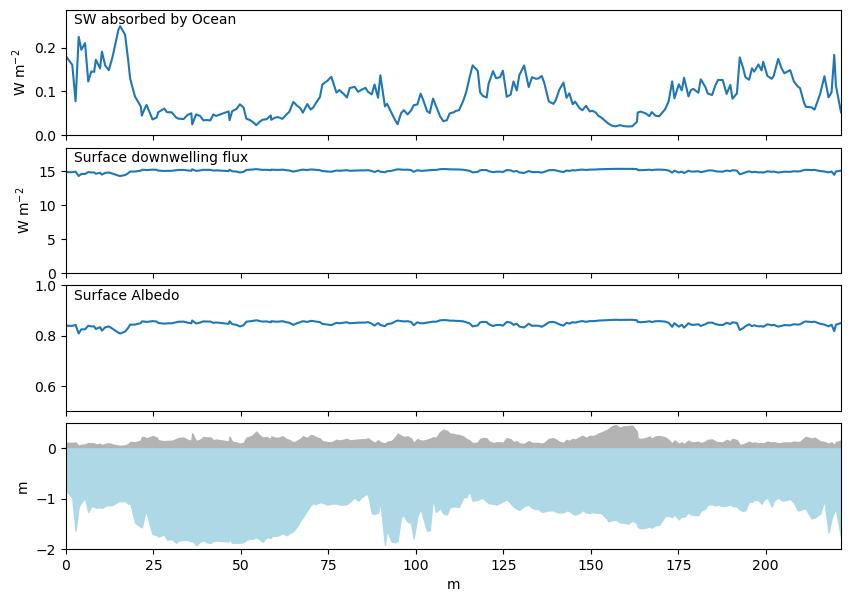

In [10]:
import matplotlib.pyplot as plt
import datetime as dt

from mosaic_thickness import plot_thickness_profile

t0 = distance[0]
t1 = distance[-1]

fig, ax = plt.subplots(4, 1, figsize=(10,7))
ax[0].set_xlim(t0, t1)
ax[0].plot(distance, sw_absorbed_by_ocean)
ax[0].set_ylim(np.array(ax[0].get_ylim()) * np.array([0., 1.1]))
ax[0].set_ylabel("$\mathrm{W\ m^{-2}}$")
ax[0].text(0.01, 0.89, "SW absorbed by Ocean", transform=ax[0].transAxes)
ax[0].set_xticklabels([])

ax[1].set_xlim(t0, t1)
ax[1].plot(distance, surface_downwelling_radiative_flux)
ax[1].set_ylim(np.array(ax[1].get_ylim()) * np.array([0., 1.2]))
ax[1].set_ylabel("$\mathrm{W\ m^{-2}}$")
ax[1].text(0.01, 0.89, "Surface downwelling flux", transform=ax[1].transAxes)
ax[1].set_xticklabels([])

ax[2].set_xlim(t0, t1)
ax[2].set_ylim(0.5, 1.0)
ax[2].plot(distance, surface_albedo)
ax[2].text(0.01, 0.89, "Surface Albedo", transform=ax[2].transAxes)
ax[2].set_xticklabels([])

# surface = np.zeros(len(df.snow_depth_m))
# snow_depth = surface - df.snow_depth_m
# ice_bottom = snow_depth - df.ice_thickness_mean_m
# ax[3].set_xlim(t0, t1)
# ax[3].set_ylim(-2.5, 0.5)
# ax[3].fill_between(distance, surface, snow_depth, color='0.7')
# ax[3].fill_between(distance, snow_depth, ice_bottom, color='lightblue')
# ax[3].set_ylabel("m")
# ax[3].set_xlabel("m")
# ax[3].text(0.01, 0.89, "Snow Depth and Ice Thickness", transform=ax[3].transAxes)
plot_thickness_profile(df, ax=ax[3])
ax[3].set_xlabel('m')
ax[3].set_ylabel("m")

fig.subplots_adjust(hspace=0.1)
fig.savefig('radiative_transfer.PS122-5_62-241.png')

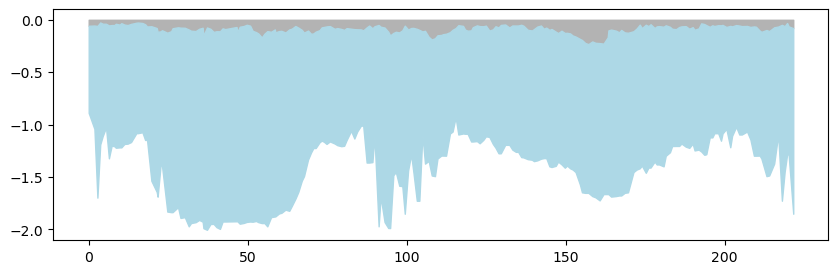

In [7]:
fig, ax = plt.subplots(figsize=(10,3))

surface = np.zeros(len(df.snow_depth_m))
snow_depth = surface - df.snow_depth_m
ice_bottom = snow_depth - df.ice_thickness_mean_m

ax.fill_between(distance, surface, snow_depth, color='0.7')
ax.fill_between(distance, snow_depth, ice_bottom, color='lightblue')

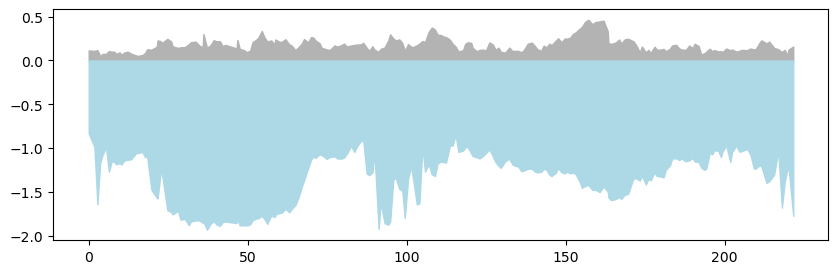

In [8]:
fig, ax = plt.subplots(figsize=(10,3))

exaggeration = 2.

snow_ice_interface = np.zeros(len(df.snow_depth_m))
snow_surface = snow_ice_interface + (df.snow_depth_m * exaggeration)
ice_ocean_interface = snow_ice_interface - df.ice_thickness_mean_m

ax.fill_between(distance, snow_surface, snow_ice_interface, color='0.7')
ax.fill_between(distance, snow_ice_interface, ice_ocean_interface, color='lightblue')
labels = ax.get_yticklabels()